# Benchmarking with sktime

The benchmarking modules allows you to easily orchestrate benchmarking experiments in which you want to compare the performance of one or more algorithms over one or more data sets. It also provides a number of statistical tests to check if observed performance differences are statistically significant.

The benchmarking modules is based on [mlaut](https://github.com/alan-turing-institute/mlaut).

## Preliminaries

In [4]:
# import required functions and classes
import os
import warnings

from sklearn.metrics import accuracy_score
from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.dictionary_based import MUSE, WEASEL, BOSSEnsemble
from sktime.classification.distance_based import ProximityForest
from sktime.classification.dummy import DummyClassifier
from sktime.classification.feature_based import TSFreshClassifier
from sktime.classification.hybrid import HIVECOTEV1, HIVECOTEV2
from sktime.classification.interval_based import (
    RandomIntervalSpectralEnsemble, TimeSeriesForestClassifier)
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.shapelet_based import MrSEQL, MrSQM
from sktime.series_as_features.model_selection import PresplitFilesCV
import pandas as pd 

# hide warnings
warnings.filterwarnings("ignore")

# set up paths to data and results folder
import sktime


DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), "datasets/data")
RESULTS_PATH = "results"

# Create individual pointers to dataset on the disk
datasets = [
    UEADataset(path=DATA_PATH, name="ArrowHead"),
    UEADataset(path=DATA_PATH, name="ItalyPowerDemand"),
    UEADataset(path=DATA_PATH, name="PLAID"),
    UEADataset(path=DATA_PATH, name="JapaneseVowels"),
    
]

# Alternatively, we can use a helper function to create them automatically
datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=["ArrowHead", "ItalyPowerDemand","PLAID","JapaneseVowels"]
)

tasks = [TSCTask(target="target") for _ in range(len(datasets))]

In [5]:
# Specify learning strategies
strategies = [
    TSCStrategy(TimeSeriesForestClassifier(n_estimators=10), name="tsf"),
    TSCStrategy(RandomIntervalSpectralEnsemble(n_estimators=10), name="rise"),
    TSCStrategy(RocketClassifier(num_kernels=500), name="rocket"),
    TSCStrategy(CNNClassifier(n_epochs=1,batch_size=4), name="CNN"),
    TSCStrategy(InceptionTimeClassifier(n_epochs=1, batch_size=64, kernel_size=40, n_filters=32), name="Inception"),
    TSCStrategy(BOSSEnsemble(), name="BOSS"),
    TSCStrategy(MUSE(), name="MUSE"),
    TSCStrategy(WEASEL(), name="WEASEL"),
    TSCStrategy(DummyClassifier(), name="Dummy"),
    
    # TSCStrategy(ProximityForest(), name="ProximityForest"), #! TypeError: '<' not supported
    # TSCStrategy(HIVECOTEV1(), name="HiveV1"), #? time consuming
    # TSCStrategy(HIVECOTEV2(), name="HiveV2"), #? time consuming
    # TSCStrategy(MrSEQL(), name="MrSEQL"), #? time consuming
    
    # TSCStrategy(TSFreshClassifier(), name="TSfresh"), #! TSFreshClassifier requires python version to be <3.10
    # TSCStrategy(MrSQM(), name="MrSQM"),  #! Could not build wheels for mrsqm
]

# Specify results object which manages the output of the benchmarking
results = HDDResults(path=RESULTS_PATH)

In [6]:
# run orchestrator
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

Number of Datasets: 4
Number of Strategies: 9
Number of CV Splits: 1
Total Iterations: 36


Fitting & Predicting:   8%|▊         | 3/36 [00:01<00:20,  1.64it/s]

44/44 [==============================] - 0s 333us/step


Fitting & Predicting:  11%|█         | 4/36 [00:02<00:18,  1.78it/s]

3/3 [==============================] - 0s 42ms/step


Fitting & Predicting:  14%|█▍        | 5/36 [00:04<00:31,  1.02s/it]

In [4]:
evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")
metrics_by_strategy = evaluator.evaluate(metric=metric)
metrics_by_strategy.head()

,strategy,accuracy_mean,accuracy_stderr
0,BOSS,0.834391,0.035426
1,CNN,0.372375,0.055593
2,Dummy,0.369042,0.055307
3,Inception,0.337053,0.054864
4,MUSE,0.895874,0.030034


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'accuracy by strategy'}, xlabel='strategies', ylabel='accuracy'>)

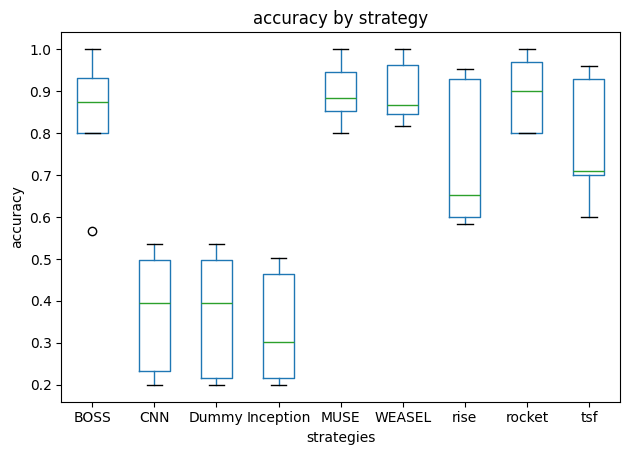

In [5]:
evaluator.plot_boxplots(metric_name="accuracy")

In [6]:
evaluator.rank(metric_name="accuracy").sort_values(by="accuracy_mean_rank")

,strategy,accuracy_mean_rank
7,rocket,2.2
5,WEASEL,2.3
4,MUSE,2.8
0,BOSS,3.9
8,tsf,4.6
6,rise,5.2
1,CNN,7.7
2,Dummy,8.0
3,Inception,8.3


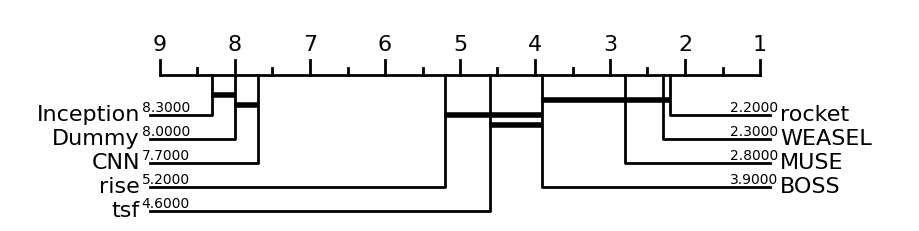

In [28]:
from utils import draw_cd_diagram

draw_cd_diagram(df_perf=evaluator.metrics_by_strategy_dataset.copy().rename(columns={"dataset":"dataset_name",
                                                             "strategy":"classifier_name",
                                                             "accuracy_mean":"accuracy"}), alpha=2.5, title=None, labels=True)